# Use historical sales data to predict future adoptions

There are two steps:
- Estimate the Bass model parameters ($p,q$, and $M$) with the historical sales data
- Use the estimated $p,q$, and $M$ to forecast future adoptions

## Estimate $p,q, M$ 

Bass model prediction for new adopters
$$\hat{A}(t) = M\cdot\frac{1-exp(-(p+q)t)}{1+\frac{q}{p}exp(-(p+q)t)}$$ <br>
$$\hat{N}(t) = \hat{A}(t)-\hat{A}(t-1)$$ <br>

The goal is to find the predicted new adoption curve ($\hat{N}(t)$) that fits the historical sales data ($N(t)$) the best. <br>

Remember Bass model requires $p>0$, $q>0$, and $M>0$. We need to include the requirement in the estimation. 

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import least_squares                 # package to conduct Nonlinear least square 

# import historical data 
url = "https://raw.githubusercontent.com/zoutianxin1992/MarketingAnalyticsPython/main/Marketing%20Analytics%20in%20Python/Bass%20model/Dataset/3-2-1%20BassModelEstimatePQM.csv"
df = pd.read_csv(url) 
# Rename the variables to t and N_t
df.rename(columns = {df.columns[0]:"t",df.columns[1]:"N"}, inplace = True)  # "inplace" apply the name change to df itself 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       14 non-null     int64  
 1   N       14 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 352.0 bytes


In [9]:
# define A_hat(t) and N_hat(t)

def A_hat(t,p,q,M):  #t: time, params: the 1*3 array for (p,q,M)
    return M * (1 - np.exp(-(p+q)*t))/(1 + q / p* np.exp(-(p+q)*t))

# define N_hat(t) 
def N_hat(t,p,q,M):  
    return A_hat(t,p,q,M) - A_hat(t-1,p,q,M)  # We can use the A_hat function to calculate N_hat instead of manually typing the formula

The formulae for SSE is 
$$SSE = \sum_{t=1}^{T}(N(t)-\hat{N}(t))^2$$

Once we know the prediction errors $e(t) = N(t)-\hat{N}(t)$ , we can calculate $SSE$. Remember the errors are determined by the Bass parameters ($p,q,M$) and the historical sales data($t,N(t)$). We already know the historical sales data, so the moving parts are $p,q,M$. In other words, the prediction errors $(e(t=1),e(t=2),...e(t=T))$ are a **function** of $p,q,M$.<br> 

Python's NLS algorithm requires us to tell it how to calculate the prediction error for each period. So, we first construct the prediction errors as a function of $p,q,M$.

In [10]:
# define prediction errors as a fucntion of p,q,M
T = len(df["N"])   # number of periods for historical data


def prediction_error(params):   # Note that we input p,q,M as a 1*3 array "params." This is required by Python's NLS solver we will use. 
    p = params[0]
    q = params[1]
    M = params[2]
    Nhat = [N_hat(t,p,q,M) for t in range(1,T+1)]            # Given p,q,M, generate Bass prediction for each period
    return df["N"] - Nhat                                 # The output is an array of prediction error for each period
                            

Our next task is to find $p,q,M$ that minimizes $SSE$ using NLS. We will use `scipy.optimize.least_squares` NLS solver. The input for the solver is `prediction_error`. <br>
[More information about least_squares](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html) <br>
To implement the solver, we need to take initial guesses for $p,q,M$. A suggested guess for Bass model is $p=0.01$, $q=0.16$, and **$M$ is three times of the current already adopters $A(t)$**. The last point is important: the estimation is often wrong when the initial guess of $M$ is too small.    

In [12]:
# estimate p,q,M using least_squares
# Bass model requires 0<p<1, 0<q<1, M>0, so we need to add the constraints
A_t = sum(df['N'])           # calculate already adopters until period t
params0 = [0.01,0.16,3*A_t]  # initial guess for p,q,M. Required by least_squares
estim_results= least_squares(prediction_error, params0, bounds = (0,np.Inf) )

#########################
# prediction_error: an array of prediction errors for each period
# param0: initial guesses
# bounds: The bounds for p,q,M. In our case p,q,M>0
#########################
estim_results
# Make sure "success" is True
# "x" is the estimated parameters (what we want).
# We don't worry about other parts for our purpose.

 active_mask: array([0, 0, 0])
        cost: 0.00016156520366259318
         fun: array([-0.00040183, -0.0029655 , -0.0030614 , -0.00121481,  0.00069782,
       -0.00312281,  0.00069343,  0.00886338,  0.00707477,  0.00178652,
       -0.01237828,  0.00083781, -0.00123377,  0.00231464])
        grad: array([9.44224809e-07, 2.96148624e-08, 3.96837492e-12])
         jac: array([[-1.58726866e+02, -5.45037054e-02, -7.30027646e-04],
       [-1.89375042e+02, -1.91372665e-01, -8.71803095e-04],
       [-2.25799467e+02, -3.78889924e-01, -1.04078663e-03],
       [-2.69028283e+02, -6.31125245e-01, -1.24206082e-03],
       [-3.20246614e+02, -9.65440340e-01, -1.48159857e-03],
       [-3.80809032e+02, -1.40310149e+00, -1.76639357e-03],
       [-4.52247304e+02, -1.96994239e+00, -2.10459867e-03],
       [-5.36269972e+02, -2.69704649e+00, -2.50566696e-03],
       [-6.34748812e+02, -3.62139395e+00, -2.98048638e-03],
       [-7.49685471e+02, -4.78638515e+00, -3.54149667e-03],
       [-8.83149295e+02, -6.24

In [ ]:
# store the estimation results
p_estim = estim_results.x[0]
q_estim = estim_results.x[1]
M_estim = estim_results.x[2]
print(p_estim, q_estim, M_estim)

0.003114243811691814 0.8329212282234183 146.19040135452215


## Predict future sales 

In [20]:
T_pred = 50  # number of periods for prediction
predictA = [A_hat(t,p_estim,q_estim,M_estim) for t in range(1,T_pred+1)]  # predict already adopters for T periods
predictN = [N_hat(t,p_estim,q_estim,M_estim) for t in range(1,T_pred+1)]  # predict new adopters for T periods

Text(0.5, 0, 'time')

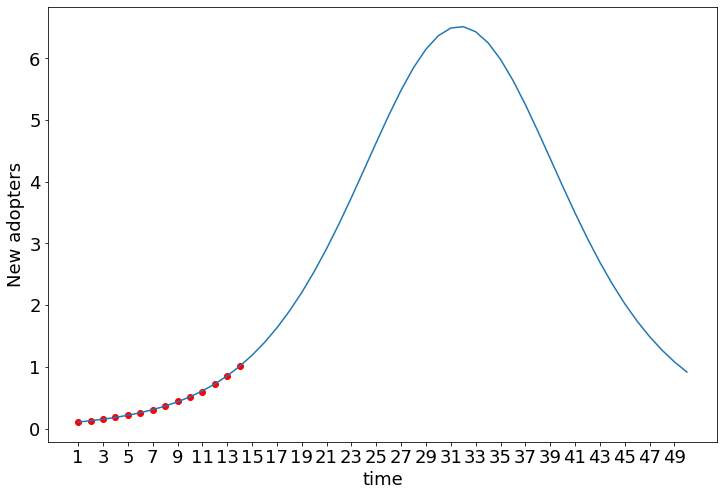

In [21]:
# Plot the trajectory of new adopters

plt.rcParams['figure.figsize'] = [12,8]  # set figure size to be 12*8 inch
plt.plot(range(1,T_pred+1),predictN)
plt.scatter(range(1,T+1),df["N"],color = "red")    # Also plot historical sales data
plt.xticks(range(1,T_pred+1,2), fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel("New adopters",fontsize = 18)
plt.xlabel("time", fontsize = 18)

## Recap